PRIMER PARCIAL

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
import math
import mlflow

In [34]:
csvToyota= pd.read_csv("ToyotaCorolla_modificado.csv")


TRATAMIENTO DE LA VARIABLE DUMMY

In [35]:
dummies=pd.get_dummies(csvToyota["Fuel_Type"])
csvToyota=csvToyota.drop(columns=["Fuel_Type"])

csvToyota[dummies.columns]=dummies


In [36]:
columns_to_delete=["Id","Model","Age_08_04","Cylinders","Weight","Radio_cassette","Power_Steering","Gears","Automatic","Radio",
                   "Power_Steering","BOVAG_Guarantee","Mfg_Month"]

df_test=csvToyota.drop(columns=columns_to_delete)
df_test.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
Price,1436.0,10730.824513,3626.964585,4350.0,8450.0,9900.0,11950.00,32500.0
Mfg_Year,1436.0,1999.625348,1.540722,1998.0,1998.0,1999.0,2001.00,2004.0
KM,1436.0,68533.259749,37506.448872,1.0,43000.0,63389.5,87020.75,243000.0
HP,1436.0,101.502089,14.981080,69.0,90.0,110.0,110.00,192.0
Met_Color,1436.0,0.674791,0.468616,0.0,0.0,1.0,1.00,1.0
cc,1436.0,1576.855850,424.386770,1300.0,1400.0,1600.0,1600.00,16000.0
Doors,1436.0,4.033426,0.952677,2.0,3.0,4.0,5.00,5.0
Quarterly_Tax,1436.0,87.122563,41.128611,19.0,69.0,85.0,85.00,283.0
Mfr_Guarantee,1436.0,0.409471,0.491907,0.0,0.0,0.0,1.00,1.0
Guarantee_Period,1436.0,3.815460,3.011025,3.0,3.0,3.0,3.00,36.0


In [37]:
outlierValuePriceDown=5000
outlierValuePriceUp=18500
df_filtered=df_test[(df_test["Price"]>outlierValuePriceDown)&(df_test["Price"]<=outlierValuePriceUp)]

<h1>CREAR EXPERIMENTO</h1>

In [38]:
experiment_name = 'ridge'

dict_values = {
    'mse':0,
    'r2_adj':0,
    'rmse':0
}


def load_create_experiment():
    if mlflow.get_experiment_by_name(experiment_name):
        return mlflow.get_experiment_by_name(experiment_name)
    return mlflow.create_experiment(experiment_name)
    
current_experiment = load_create_experiment()
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///C:/Users/USUARIO/Desktop/ISI/5to%20a%C3%B1o/Inteligencia%20Empresarial%20y%20Datamining/Actividades/Actividad%205%20-%2010-10-2022/mlruns/7', creation_time=1666710021527, experiment_id='7', last_update_time=1666710021527, lifecycle_stage='active', name='ridge', tags={}>

In [39]:
mlflow.start_run()

<ActiveRun: >

<h1 style="color: cyan">NORMALIZACION</h1>

In [40]:
scaler=MinMaxScaler()
norm_data=scaler.fit_transform(df_filtered)
dataset=pd.DataFrame(norm_data,columns=df_test.columns.values)
dataset.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
Price,1351.0,0.373303,0.194722,0.0,0.232210,0.344569,0.471910,1.0
Mfg_Year,1351.0,0.237478,0.222228,0.0,0.000000,0.166667,0.333333,1.0
KM,1351.0,0.292132,0.149570,0.0,0.189091,0.268553,0.365855,1.0
HP,1351.0,0.671481,0.271844,0.0,0.361702,0.872340,0.872340,1.0
Met_Color,1351.0,0.669134,0.470699,0.0,0.000000,1.000000,1.000000,1.0
cc,1351.0,0.367642,0.262234,0.0,0.142857,0.428571,0.428571,1.0
Doors,1351.0,0.668641,0.317391,0.0,0.333333,0.666667,1.000000,1.0
Quarterly_Tax,1351.0,0.307858,0.177900,0.0,0.232558,0.306977,0.306977,1.0
Mfr_Guarantee,1351.0,0.404145,0.490908,0.0,0.000000,0.000000,1.000000,1.0
Guarantee_Period,1351.0,0.023821,0.087870,0.0,0.000000,0.000000,0.000000,1.0


<h3 style="color: lightgreen">MODELO: RIDGE</h3>

In [41]:
Y=df_filtered[["Price"]]
X=dataset[["Mfg_Year","KM","Quarterly_Tax","Guarantee_Period","Automatic_airco","Airco","Doors","Mfr_Guarantee"]]

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_7428\615492939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y["Price"]=np.log(Y["Price"])


(array([ 10.,  38., 124., 226., 299., 297., 153.,  98.,  52.,  54.]),
 array([8.54675199, 8.6746294 , 8.8025068 , 8.9303842 , 9.0582616 ,
        9.186139  , 9.3140164 , 9.44189381, 9.56977121, 9.69764861,
        9.82552601]),
 <BarContainer object of 10 artists>)

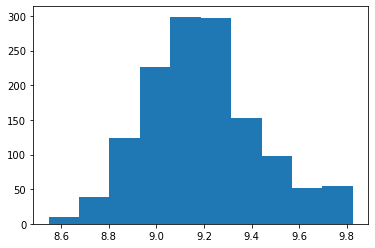

In [42]:
Y["Price"]=np.log(Y["Price"])
plt.hist(Y["Price"],bins=10)

In [43]:
X.shape, Y.shape

((1351, 8), (1351, 1))

In [44]:
datasetsize=X.shape[0]
datasetsize

1351

In [45]:
percentRemoved=0

percentRemoved= (csvToyota.shape[0]-datasetsize)/csvToyota.shape[0] * 100

percentRemoved

5.919220055710307

In [46]:
x_train, x_test, y_train, y_test= train_test_split(X,Y,test_size=0.3,random_state=42,shuffle=True)
x_train=x_train.reset_index(drop=True)
x_test=x_test.reset_index(drop=True)
y_train=y_train.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)
    

model=sm.OLS(y_train,sm.add_constant(x_train))
ml_results=model.fit()

In [47]:
y_pred = ml_results.predict(sm.add_constant(x_test))

In [48]:
print(y_pred.T)

0      9.249922
1      9.481132
2      9.202866
3      9.151052
4      8.990217
         ...   
401    9.283709
402    8.922323
403    9.702456
404    9.479622
405    9.072074
Length: 406, dtype: float64


In [49]:
mse=mean_squared_error(y_test,y_pred)
print("Mean squared error:" ,mse)

Mean squared error: 0.010586502671881942


In [50]:
print("Root mean squared error: " ,math.sqrt(mse))

Root mean squared error:  0.1028907317103049


In [51]:
summary=ml_results.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     552.6
Date:                Tue, 25 Oct 2022   Prob (F-statistic):               0.00
Time:                        12:03:30   Log-Likelihood:                 807.17
No. Observations:                 945   AIC:                            -1596.
Df Residuals:                     936   BIC:                            -1553.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                9.0141      0.013  

In [52]:
# Valores Ajustados
fitted_values = ml_results.fittedvalues

# Valores residuales
residuals = ml_results.resid

#residuales estandarizados
lm_resid_stand = ml_results.get_influence().resid_studentized_internal

#raiz de los residuales normalizados absolutos
lm_resid_norm_abs_sqrt = np.sqrt(np.abs(lm_resid_stand))

#residuales absolutos
lm_resid_abs = np.abs(residuals)

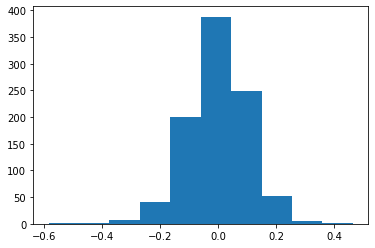

In [53]:
# Residuales
plt.hist(ml_results.resid)
plt.show()

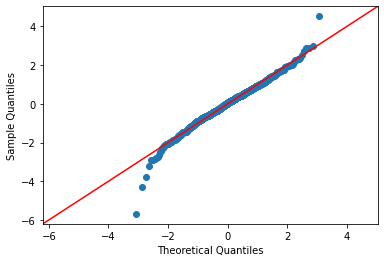

In [54]:
fig = sm.qqplot(lm_resid_stand,line='45')
plt.show()

Text(0, 0.5, 'Residuals')

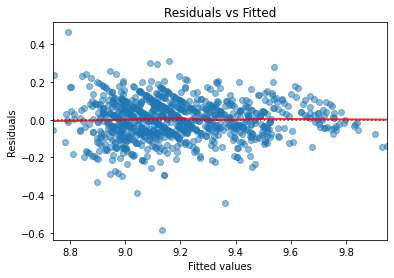

In [55]:
plot = sns.residplot(x=fitted_values, y=residuals, lowess=True,
                     scatter_kws={'alpha': 0.5},
                     line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})

# Titel and labels
plot.set_title('Residuals vs Fitted')
plot.set_xlabel('Fitted values')
plot.set_ylabel('Residuals')



<h1 style="color: violet">VALIDACION CON X-VALIDATION</h1>

In [56]:
Y=df_filtered[["Price"]]
X=dataset[["Mfg_Year","KM","Quarterly_Tax","Guarantee_Period","Automatic_airco","Airco","Doors","Mfr_Guarantee"]]

In [57]:
Y["Price"]=np.log(Y["Price"])

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_7428\3880681737.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y["Price"]=np.log(Y["Price"])


In [58]:
from sklearn.metrics import get_scorer_names

get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [59]:
kfold_param = {
    'n_splits':10,
    'shuffle':True,
    'random_state':42
}

kfold = KFold(**kfold_param)

clf_dt = LinearRegression()

score = cross_val_score(clf_dt, X, Y,cv=kfold, n_jobs=-1,scoring="neg_mean_squared_error")

In [60]:
print(score)

[-0.00956207 -0.01130283 -0.01065286 -0.01193912 -0.01081364 -0.0101154
 -0.00942402 -0.01146191 -0.01030062 -0.011595  ]


In [61]:
np.mean(abs(score))

0.010716745801346208

In [62]:
math.sqrt(np.mean(abs(score)))

0.10352171656877704

<h1>GUARDAR EXPERIMENTO</h1>

In [63]:
from math import sqrt

dict_values = {
    'mse': mse,
    'r2_adj': ml_results.rsquared_adj,
    'rmse':sqrt(mse),
    'PriceValueTruncDown' : outlierValuePriceDown,
    'PriceValueTruncUp': outlierValuePriceUp
}

mlflow.set_tag('DatasetSize', datasetsize)
mlflow.set_tag('PercentageDataRemoved',percentRemoved)
mlflow.set_tag('Summary',summary)


mlflow.log_metrics(dict_values)

FINALIZAR EXPERIMENTO

In [64]:
mlflow.end_run()